In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 216s 216s/step - loss: 71372.2344
Epoch 2/3000
1/1 [==============================] - 0s 50ms/step - loss: 70915.7500
Epoch 3/3000
1/1 [==============================] - 0s 47ms/step - loss: 70581.4062
Epoch 4/3000
1/1 [==============================] - 0s 48ms/step - loss: 70295.0625
Epoch 5/3000
1/1 [==============================] - 0s 47ms/step - loss: 70036.0312
Epoch 6/3000
1/1 [==============================] - 0s 45ms/step - loss: 69795.2188
Epoch 7/3000
1/1 [==============================] - 0s 46ms/step - loss: 69567.7109
Epoch 8/3000
1/1 [==============================] - 0s 46ms/step - loss: 69350.4219
Epoch 9/3000
1/1 [==============================] - 0s 45ms/step - loss: 69141.2812
Epoch 10/3000
1/1 [==============================] - 0s 46ms/step - loss: 68938.7500
Epoch 11/3000
1/1 [==============================] - 0s 46ms/step - loss: 68741.7188
Epoch 12/3000
1/1 [==============================] - 0s 47ms/step - loss

1/1 [==============================] - 0s 69ms/step - loss: 59058.3906
Epoch 98/3000
1/1 [==============================] - 0s 71ms/step - loss: 58992.3789
Epoch 99/3000
1/1 [==============================] - 0s 67ms/step - loss: 58927.0000
Epoch 100/3000
1/1 [==============================] - 0s 69ms/step - loss: 58862.2188
Epoch 101/3000
1/1 [==============================] - 0s 74ms/step - loss: 58798.0625
Epoch 102/3000
1/1 [==============================] - 0s 70ms/step - loss: 58734.5000
Epoch 103/3000
1/1 [==============================] - 0s 71ms/step - loss: 58671.5234
Epoch 104/3000
1/1 [==============================] - 0s 68ms/step - loss: 58609.1406
Epoch 105/3000
1/1 [==============================] - 0s 68ms/step - loss: 58547.3242
Epoch 106/3000
1/1 [==============================] - 0s 69ms/step - loss: 58486.0742
Epoch 107/3000
1/1 [==============================] - 0s 69ms/step - loss: 58425.3789
Epoch 108/3000
1/1 [==============================] - 0s 69ms/step - lo

1/1 [==============================] - 0s 69ms/step - loss: 54670.1562
Epoch 193/3000
1/1 [==============================] - 0s 73ms/step - loss: 54637.1562
Epoch 194/3000
1/1 [==============================] - 0s 114ms/step - loss: 54604.3164
Epoch 195/3000
1/1 [==============================] - 0s 93ms/step - loss: 54571.6523
Epoch 196/3000
1/1 [==============================] - 0s 119ms/step - loss: 54539.1406
Epoch 197/3000
1/1 [==============================] - 0s 75ms/step - loss: 54506.8086
Epoch 198/3000
1/1 [==============================] - 0s 71ms/step - loss: 54474.6328
Epoch 199/3000
1/1 [==============================] - 0s 73ms/step - loss: 54442.6211
Epoch 200/3000
1/1 [==============================] - 0s 71ms/step - loss: 54410.7656
Epoch 201/3000
1/1 [==============================] - 0s 71ms/step - loss: 54379.0625
Epoch 202/3000
1/1 [==============================] - 0s 71ms/step - loss: 54347.5156
Epoch 203/3000
1/1 [==============================] - 0s 70ms/step 

1/1 [==============================] - 0s 70ms/step - loss: 52081.6250
Epoch 288/3000
1/1 [==============================] - 0s 79ms/step - loss: 52058.5391
Epoch 289/3000
1/1 [==============================] - 0s 74ms/step - loss: 52035.5000
Epoch 290/3000
1/1 [==============================] - 0s 72ms/step - loss: 52012.5234
Epoch 291/3000
1/1 [==============================] - 0s 73ms/step - loss: 51989.6094
Epoch 292/3000
1/1 [==============================] - 0s 75ms/step - loss: 51966.7500
Epoch 293/3000
1/1 [==============================] - 0s 75ms/step - loss: 51943.9531
Epoch 294/3000
1/1 [==============================] - 0s 71ms/step - loss: 51921.2109
Epoch 295/3000
1/1 [==============================] - 0s 70ms/step - loss: 51898.5273
Epoch 296/3000
1/1 [==============================] - 0s 72ms/step - loss: 51875.8984
Epoch 297/3000
1/1 [==============================] - 0s 71ms/step - loss: 51853.3203
Epoch 298/3000
1/1 [==============================] - 0s 72ms/step - 

1/1 [==============================] - 0s 67ms/step - loss: 50097.6211
Epoch 383/3000
1/1 [==============================] - 0s 68ms/step - loss: 50078.5117
Epoch 384/3000
1/1 [==============================] - 0s 66ms/step - loss: 50059.4258
Epoch 385/3000
1/1 [==============================] - 0s 67ms/step - loss: 50040.3789
Epoch 386/3000
1/1 [==============================] - 0s 67ms/step - loss: 50021.3594
Epoch 387/3000
1/1 [==============================] - 0s 67ms/step - loss: 50002.3672
Epoch 388/3000
1/1 [==============================] - 0s 67ms/step - loss: 49983.3945
Epoch 389/3000
1/1 [==============================] - 0s 67ms/step - loss: 49964.4688
Epoch 390/3000
1/1 [==============================] - 0s 67ms/step - loss: 49945.5625
Epoch 391/3000
1/1 [==============================] - 0s 66ms/step - loss: 49926.6875
Epoch 392/3000
1/1 [==============================] - 0s 67ms/step - loss: 49907.8359
Epoch 393/3000
1/1 [==============================] - 0s 66ms/step - 

1/1 [==============================] - 0s 66ms/step - loss: 48396.5781
Epoch 478/3000
1/1 [==============================] - 0s 66ms/step - loss: 48379.7578
Epoch 479/3000
1/1 [==============================] - 0s 66ms/step - loss: 48362.9609
Epoch 480/3000
1/1 [==============================] - 0s 64ms/step - loss: 48346.1875
Epoch 481/3000
1/1 [==============================] - 0s 67ms/step - loss: 48329.4336
Epoch 482/3000
1/1 [==============================] - 0s 66ms/step - loss: 48312.6953
Epoch 483/3000
1/1 [==============================] - 0s 66ms/step - loss: 48295.9844
Epoch 484/3000
1/1 [==============================] - 0s 67ms/step - loss: 48279.2812
Epoch 485/3000
1/1 [==============================] - 0s 64ms/step - loss: 48262.6172
Epoch 486/3000
1/1 [==============================] - 0s 66ms/step - loss: 48245.9609
Epoch 487/3000
1/1 [==============================] - 0s 67ms/step - loss: 48229.3203
Epoch 488/3000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 70ms/step - loss: 46886.0781
Epoch 573/3000
1/1 [==============================] - 0s 71ms/step - loss: 46871.0781
Epoch 574/3000
1/1 [==============================] - 0s 69ms/step - loss: 46856.0898
Epoch 575/3000
1/1 [==============================] - 0s 69ms/step - loss: 46841.1289
Epoch 576/3000
1/1 [==============================] - 0s 70ms/step - loss: 46826.1797
Epoch 577/3000
1/1 [==============================] - 0s 68ms/step - loss: 46811.2500
Epoch 578/3000
1/1 [==============================] - 0s 69ms/step - loss: 46796.3438
Epoch 579/3000
1/1 [==============================] - 0s 68ms/step - loss: 46781.4492
Epoch 580/3000
1/1 [==============================] - 0s 71ms/step - loss: 46766.5742
Epoch 581/3000
1/1 [==============================] - 0s 71ms/step - loss: 46751.7188
Epoch 582/3000
1/1 [==============================] - 0s 70ms/step - loss: 46736.8906
Epoch 583/3000
1/1 [==============================] - 0s 69ms/step - 

1/1 [==============================] - 0s 66ms/step - loss: 45534.9961
Epoch 668/3000
1/1 [==============================] - 0s 65ms/step - loss: 45521.5234
Epoch 669/3000
1/1 [==============================] - 0s 67ms/step - loss: 45508.0625
Epoch 670/3000
1/1 [==============================] - 0s 67ms/step - loss: 45494.6172
Epoch 671/3000
1/1 [==============================] - 0s 66ms/step - loss: 45481.1914
Epoch 672/3000
1/1 [==============================] - 0s 67ms/step - loss: 45467.7734
Epoch 673/3000
1/1 [==============================] - 0s 66ms/step - loss: 45454.3750
Epoch 674/3000
1/1 [==============================] - 0s 65ms/step - loss: 45440.9844
Epoch 675/3000
1/1 [==============================] - 0s 65ms/step - loss: 45427.6133
Epoch 676/3000
1/1 [==============================] - 0s 65ms/step - loss: 45414.2578
Epoch 677/3000
1/1 [==============================] - 0s 66ms/step - loss: 45400.9141
Epoch 678/3000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 67ms/step - loss: 44312.1641
Epoch 763/3000
1/1 [==============================] - 0s 67ms/step - loss: 44299.8203
Epoch 764/3000
1/1 [==============================] - 0s 67ms/step - loss: 44287.4844
Epoch 765/3000
1/1 [==============================] - 0s 66ms/step - loss: 44275.1484
Epoch 766/3000
1/1 [==============================] - 0s 66ms/step - loss: 44262.8359
Epoch 767/3000
1/1 [==============================] - 0s 66ms/step - loss: 44250.5234
Epoch 768/3000
1/1 [==============================] - 0s 66ms/step - loss: 44238.2188
Epoch 769/3000
1/1 [==============================] - 0s 64ms/step - loss: 44225.9219
Epoch 770/3000
1/1 [==============================] - 0s 66ms/step - loss: 44213.6445
Epoch 771/3000
1/1 [==============================] - 0s 65ms/step - loss: 44201.3594
Epoch 772/3000
1/1 [==============================] - 0s 67ms/step - loss: 44189.0859
Epoch 773/3000
1/1 [==============================] - 0s 65ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 43104.9883
Epoch 858/3000
1/1 [==============================] - 0s 65ms/step - loss: 43092.1719
Epoch 859/3000
1/1 [==============================] - 0s 66ms/step - loss: 43079.4531
Epoch 860/3000
1/1 [==============================] - 0s 66ms/step - loss: 43066.7891
Epoch 861/3000
1/1 [==============================] - 0s 66ms/step - loss: 43054.1836
Epoch 862/3000
1/1 [==============================] - 0s 66ms/step - loss: 43041.6289
Epoch 863/3000
1/1 [==============================] - 0s 65ms/step - loss: 43029.1328
Epoch 864/3000
1/1 [==============================] - 0s 65ms/step - loss: 43016.6680
Epoch 865/3000
1/1 [==============================] - 0s 66ms/step - loss: 43004.2422
Epoch 866/3000
1/1 [==============================] - 0s 66ms/step - loss: 42991.8594
Epoch 867/3000
1/1 [==============================] - 0s 67ms/step - loss: 42979.5156
Epoch 868/3000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 42011.7109
Epoch 953/3000
1/1 [==============================] - 0s 72ms/step - loss: 42000.9297
Epoch 954/3000
1/1 [==============================] - 0s 65ms/step - loss: 41990.0938
Epoch 955/3000
1/1 [==============================] - 0s 65ms/step - loss: 41979.3477
Epoch 956/3000
1/1 [==============================] - 0s 64ms/step - loss: 41968.5391
Epoch 957/3000
1/1 [==============================] - 0s 65ms/step - loss: 41957.8242
Epoch 958/3000
1/1 [==============================] - 0s 65ms/step - loss: 41947.0547
Epoch 959/3000
1/1 [==============================] - 0s 66ms/step - loss: 41936.3672
Epoch 960/3000
1/1 [==============================] - 0s 66ms/step - loss: 41925.6094
Epoch 961/3000
1/1 [==============================] - 0s 66ms/step - loss: 41914.9453
Epoch 962/3000
1/1 [==============================] - 0s 65ms/step - loss: 41904.1953
Epoch 963/3000
1/1 [==============================] - 0s 68ms/step - 

1/1 [==============================] - 0s 69ms/step - loss: 41049.4414
Epoch 1047/3000
1/1 [==============================] - 0s 70ms/step - loss: 41039.8438
Epoch 1048/3000
1/1 [==============================] - 0s 70ms/step - loss: 41030.1875
Epoch 1049/3000
1/1 [==============================] - 0s 74ms/step - loss: 41020.6055
Epoch 1050/3000
1/1 [==============================] - 0s 70ms/step - loss: 41010.9766
Epoch 1051/3000
1/1 [==============================] - 0s 67ms/step - loss: 41001.4297
Epoch 1052/3000
1/1 [==============================] - 0s 67ms/step - loss: 40991.8281
Epoch 1053/3000
1/1 [==============================] - 0s 68ms/step - loss: 40982.3008
Epoch 1054/3000
1/1 [==============================] - 0s 68ms/step - loss: 40972.7188
Epoch 1055/3000
1/1 [==============================] - 0s 68ms/step - loss: 40963.2266
Epoch 1056/3000
1/1 [==============================] - 0s 68ms/step - loss: 40953.6719
Epoch 1057/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 65ms/step - loss: 40202.4336
Epoch 1141/3000
1/1 [==============================] - 0s 65ms/step - loss: 40194.1250
Epoch 1142/3000
1/1 [==============================] - 0s 66ms/step - loss: 40185.7344
Epoch 1143/3000
1/1 [==============================] - 0s 67ms/step - loss: 40177.4531
Epoch 1144/3000
1/1 [==============================] - 0s 67ms/step - loss: 40169.1016
Epoch 1145/3000
1/1 [==============================] - 0s 67ms/step - loss: 40160.8516
Epoch 1146/3000
1/1 [==============================] - 0s 66ms/step - loss: 40152.5234
Epoch 1147/3000
1/1 [==============================] - 0s 67ms/step - loss: 40144.3047
Epoch 1148/3000
1/1 [==============================] - 0s 67ms/step - loss: 40135.9961
Epoch 1149/3000
1/1 [==============================] - 0s 67ms/step - loss: 40127.8047
Epoch 1150/3000
1/1 [==============================] - 0s 66ms/step - loss: 40119.5391
Epoch 1151/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 39480.3867
Epoch 1235/3000
1/1 [==============================] - 0s 66ms/step - loss: 39473.4609
Epoch 1236/3000
1/1 [==============================] - 0s 66ms/step - loss: 39466.4375
Epoch 1237/3000
1/1 [==============================] - 0s 66ms/step - loss: 39459.5391
Epoch 1238/3000
1/1 [==============================] - 0s 68ms/step - loss: 39452.5469
Epoch 1239/3000
1/1 [==============================] - 0s 66ms/step - loss: 39445.6797
Epoch 1240/3000
1/1 [==============================] - 0s 66ms/step - loss: 39438.7148
Epoch 1241/3000
1/1 [==============================] - 0s 67ms/step - loss: 39431.8711
Epoch 1242/3000
1/1 [==============================] - 0s 66ms/step - loss: 39424.9414
Epoch 1243/3000
1/1 [==============================] - 0s 66ms/step - loss: 39418.1250
Epoch 1244/3000
1/1 [==============================] - 0s 66ms/step - loss: 39411.2188
Epoch 1245/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 38886.5078
Epoch 1329/3000
1/1 [==============================] - 0s 66ms/step - loss: 38880.9219
Epoch 1330/3000
1/1 [==============================] - 0s 65ms/step - loss: 38875.2227
Epoch 1331/3000
1/1 [==============================] - 0s 65ms/step - loss: 38869.6719
Epoch 1332/3000
1/1 [==============================] - 0s 67ms/step - loss: 38864.0039
Epoch 1333/3000
1/1 [==============================] - 0s 67ms/step - loss: 38858.4766
Epoch 1334/3000
1/1 [==============================] - 0s 65ms/step - loss: 38852.8359
Epoch 1335/3000
1/1 [==============================] - 0s 67ms/step - loss: 38847.3398
Epoch 1336/3000
1/1 [==============================] - 0s 67ms/step - loss: 38841.7266
Epoch 1337/3000
1/1 [==============================] - 0s 65ms/step - loss: 38836.2578
Epoch 1338/3000
1/1 [==============================] - 0s 67ms/step - loss: 38830.6719
Epoch 1339/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 38392.5742
Epoch 1423/3000
1/1 [==============================] - 0s 66ms/step - loss: 38383.6445
Epoch 1424/3000
1/1 [==============================] - 0s 66ms/step - loss: 38374.2422
Epoch 1425/3000
1/1 [==============================] - 0s 66ms/step - loss: 38365.3242
Epoch 1426/3000
1/1 [==============================] - 0s 65ms/step - loss: 38356.6641
Epoch 1427/3000
1/1 [==============================] - 0s 66ms/step - loss: 38348.4961
Epoch 1428/3000
1/1 [==============================] - 0s 66ms/step - loss: 38340.2734
Epoch 1429/3000
1/1 [==============================] - 0s 66ms/step - loss: 38332.3242
Epoch 1430/3000
1/1 [==============================] - 0s 65ms/step - loss: 38323.9062
Epoch 1431/3000
1/1 [==============================] - 0s 65ms/step - loss: 38315.3711
Epoch 1432/3000
1/1 [==============================] - 0s 66ms/step - loss: 38306.0312
Epoch 1433/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 37942.1250
Epoch 1517/3000
1/1 [==============================] - 0s 68ms/step - loss: 37938.5742
Epoch 1518/3000
1/1 [==============================] - 0s 69ms/step - loss: 37934.7031
Epoch 1519/3000
1/1 [==============================] - 0s 69ms/step - loss: 37931.1680
Epoch 1520/3000
1/1 [==============================] - 0s 67ms/step - loss: 37927.3203
Epoch 1521/3000
1/1 [==============================] - 0s 67ms/step - loss: 37923.8008
Epoch 1522/3000
1/1 [==============================] - 0s 64ms/step - loss: 37919.9609
Epoch 1523/3000
1/1 [==============================] - 0s 68ms/step - loss: 37916.4531
Epoch 1524/3000
1/1 [==============================] - 0s 66ms/step - loss: 37912.6250
Epoch 1525/3000
1/1 [==============================] - 0s 67ms/step - loss: 37909.1211
Epoch 1526/3000
1/1 [==============================] - 0s 66ms/step - loss: 37905.3125
Epoch 1527/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 65ms/step - loss: 37287.3438
Epoch 1611/3000
1/1 [==============================] - 0s 66ms/step - loss: 37275.2188
Epoch 1612/3000
1/1 [==============================] - 0s 67ms/step - loss: 37266.8047
Epoch 1613/3000
1/1 [==============================] - 0s 67ms/step - loss: 37255.4570
Epoch 1614/3000
1/1 [==============================] - 0s 66ms/step - loss: 37246.9297
Epoch 1615/3000
1/1 [==============================] - 0s 67ms/step - loss: 37236.3516
Epoch 1616/3000
1/1 [==============================] - 0s 66ms/step - loss: 37227.8945
Epoch 1617/3000
1/1 [==============================] - 0s 65ms/step - loss: 37217.8516
Epoch 1618/3000
1/1 [==============================] - 0s 65ms/step - loss: 37209.4375
Epoch 1619/3000
1/1 [==============================] - 0s 67ms/step - loss: 37199.6602
Epoch 1620/3000
1/1 [==============================] - 0s 65ms/step - loss: 37191.1875
Epoch 1621/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 36357.2969
Epoch 1705/3000
1/1 [==============================] - 0s 66ms/step - loss: 36338.4648
Epoch 1706/3000
1/1 [==============================] - 0s 66ms/step - loss: 36336.0547
Epoch 1707/3000
1/1 [==============================] - 0s 66ms/step - loss: 36316.8984
Epoch 1708/3000
1/1 [==============================] - 0s 67ms/step - loss: 36314.7383
Epoch 1709/3000
1/1 [==============================] - 0s 66ms/step - loss: 36295.2891
Epoch 1710/3000
1/1 [==============================] - 0s 66ms/step - loss: 36293.3633
Epoch 1711/3000
1/1 [==============================] - 0s 67ms/step - loss: 36273.5703
Epoch 1712/3000
1/1 [==============================] - 0s 64ms/step - loss: 36271.9062
Epoch 1713/3000
1/1 [==============================] - 0s 66ms/step - loss: 36251.7891
Epoch 1714/3000
1/1 [==============================] - 0s 65ms/step - loss: 36250.3906
Epoch 1715/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 35334.9531
Epoch 1799/3000
1/1 [==============================] - 0s 67ms/step - loss: 35309.9375
Epoch 1800/3000
1/1 [==============================] - 0s 65ms/step - loss: 35313.4844
Epoch 1801/3000
1/1 [==============================] - 0s 65ms/step - loss: 35287.6484
Epoch 1802/3000
1/1 [==============================] - 0s 65ms/step - loss: 35291.1016
Epoch 1803/3000
1/1 [==============================] - 0s 66ms/step - loss: 35265.5859
Epoch 1804/3000
1/1 [==============================] - 0s 68ms/step - loss: 35269.3672
Epoch 1805/3000
1/1 [==============================] - 0s 70ms/step - loss: 35243.2891
Epoch 1806/3000
1/1 [==============================] - 0s 71ms/step - loss: 35247.1992
Epoch 1807/3000
1/1 [==============================] - 0s 69ms/step - loss: 35220.8828
Epoch 1808/3000
1/1 [==============================] - 0s 69ms/step - loss: 35225.2812
Epoch 1809/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 34373.3359
Epoch 1893/3000
1/1 [==============================] - 0s 66ms/step - loss: 34340.9922
Epoch 1894/3000
1/1 [==============================] - 0s 65ms/step - loss: 34361.0312
Epoch 1895/3000
1/1 [==============================] - 0s 65ms/step - loss: 34325.2266
Epoch 1896/3000
1/1 [==============================] - 0s 67ms/step - loss: 34344.0547
Epoch 1897/3000
1/1 [==============================] - 0s 66ms/step - loss: 34307.4961
Epoch 1898/3000
1/1 [==============================] - 0s 65ms/step - loss: 34326.4766
Epoch 1899/3000
1/1 [==============================] - 0s 64ms/step - loss: 34290.4141
Epoch 1900/3000
1/1 [==============================] - 0s 68ms/step - loss: 34310.1914
Epoch 1901/3000
1/1 [==============================] - 0s 67ms/step - loss: 34272.9609
Epoch 1902/3000
1/1 [==============================] - 0s 65ms/step - loss: 34293.2422
Epoch 1903/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 33795.8047
Epoch 1987/3000
1/1 [==============================] - 0s 66ms/step - loss: 33754.2969
Epoch 1988/3000
1/1 [==============================] - 0s 66ms/step - loss: 33783.2461
Epoch 1989/3000
1/1 [==============================] - 0s 66ms/step - loss: 33741.1562
Epoch 1990/3000
1/1 [==============================] - 0s 65ms/step - loss: 33774.0000
Epoch 1991/3000
1/1 [==============================] - 0s 66ms/step - loss: 33733.8945
Epoch 1992/3000
1/1 [==============================] - 0s 67ms/step - loss: 33772.8398
Epoch 1993/3000
1/1 [==============================] - 0s 67ms/step - loss: 33725.3398
Epoch 1994/3000
1/1 [==============================] - 0s 65ms/step - loss: 33768.5938
Epoch 1995/3000
1/1 [==============================] - 0s 67ms/step - loss: 33715.6758
Epoch 1996/3000
1/1 [==============================] - 0s 65ms/step - loss: 33769.2188
Epoch 1997/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 33522.5703
Epoch 2081/3000
1/1 [==============================] - 0s 65ms/step - loss: 33419.0195
Epoch 2082/3000
1/1 [==============================] - 0s 68ms/step - loss: 33464.1367
Epoch 2083/3000
1/1 [==============================] - 0s 67ms/step - loss: 33434.0859
Epoch 2084/3000
1/1 [==============================] - 0s 67ms/step - loss: 33491.3203
Epoch 2085/3000
1/1 [==============================] - 0s 67ms/step - loss: 33442.9219
Epoch 2086/3000
1/1 [==============================] - 0s 67ms/step - loss: 33493.6719
Epoch 2087/3000
1/1 [==============================] - 0s 67ms/step - loss: 33433.7734
Epoch 2088/3000
1/1 [==============================] - 0s 67ms/step - loss: 33488.6406
Epoch 2089/3000
1/1 [==============================] - 0s 72ms/step - loss: 33414.0547
Epoch 2090/3000
1/1 [==============================] - 0s 69ms/step - loss: 33470.3281
Epoch 2091/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 33287.5391
Epoch 2175/3000
1/1 [==============================] - 0s 67ms/step - loss: 33221.2188
Epoch 2176/3000
1/1 [==============================] - 0s 67ms/step - loss: 33307.4062
Epoch 2177/3000
1/1 [==============================] - 0s 65ms/step - loss: 33226.8047
Epoch 2178/3000
1/1 [==============================] - 0s 68ms/step - loss: 33381.1562
Epoch 2179/3000
1/1 [==============================] - 0s 65ms/step - loss: 33253.8281
Epoch 2180/3000
1/1 [==============================] - 0s 65ms/step - loss: 33297.1250
Epoch 2181/3000
1/1 [==============================] - 0s 66ms/step - loss: 33172.5156
Epoch 2182/3000
1/1 [==============================] - 0s 67ms/step - loss: 33197.4336
Epoch 2183/3000
1/1 [==============================] - 0s 66ms/step - loss: 33158.7500
Epoch 2184/3000
1/1 [==============================] - 0s 66ms/step - loss: 33226.2070
Epoch 2185/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 72ms/step - loss: 33112.5391
Epoch 2269/3000
1/1 [==============================] - 0s 72ms/step - loss: 33042.8750
Epoch 2270/3000
1/1 [==============================] - 0s 69ms/step - loss: 33132.8906
Epoch 2271/3000
1/1 [==============================] - 0s 69ms/step - loss: 33032.1953
Epoch 2272/3000
1/1 [==============================] - 0s 72ms/step - loss: 33159.8867
Epoch 2273/3000
1/1 [==============================] - 0s 71ms/step - loss: 33025.7031
Epoch 2274/3000
1/1 [==============================] - 0s 70ms/step - loss: 33120.9297
Epoch 2275/3000
1/1 [==============================] - 0s 76ms/step - loss: 33048.1406
Epoch 2276/3000
1/1 [==============================] - 0s 73ms/step - loss: nan
Epoch 2277/3000
1/1 [==============================] - 0s 70ms/step - loss: 32982.3594
Epoch 2278/3000
1/1 [==============================] - 0s 70ms/step - loss: 32995.9492
Epoch 2279/3000
1/1 [==============================] - 0s 70ms/ste

1/1 [==============================] - 0s 67ms/step - loss: 32985.0352
Epoch 2363/3000
1/1 [==============================] - 0s 66ms/step - loss: 32985.0898
Epoch 2364/3000
1/1 [==============================] - 0s 67ms/step - loss: 33162.8594
Epoch 2365/3000
1/1 [==============================] - 0s 66ms/step - loss: 32887.4102
Epoch 2366/3000
1/1 [==============================] - 0s 66ms/step - loss: 32852.4492
Epoch 2367/3000
1/1 [==============================] - 0s 66ms/step - loss: 32782.9570
Epoch 2368/3000
1/1 [==============================] - 0s 66ms/step - loss: 32822.3984
Epoch 2369/3000
1/1 [==============================] - 0s 67ms/step - loss: 32838.3984
Epoch 2370/3000
1/1 [==============================] - 0s 66ms/step - loss: 32953.4297
Epoch 2371/3000
1/1 [==============================] - 0s 66ms/step - loss: 32943.9922
Epoch 2372/3000
1/1 [==============================] - 0s 66ms/step - loss: 33035.3320
Epoch 2373/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 32819.7656
Epoch 2457/3000
1/1 [==============================] - 0s 67ms/step - loss: 32772.0469
Epoch 2458/3000
1/1 [==============================] - 0s 66ms/step - loss: 32817.8047
Epoch 2459/3000
1/1 [==============================] - 0s 67ms/step - loss: 32768.2617
Epoch 2460/3000
1/1 [==============================] - 0s 65ms/step - loss: nan
Epoch 2461/3000
1/1 [==============================] - 0s 67ms/step - loss: 38458.9648
Epoch 2462/3000
1/1 [==============================] - 0s 66ms/step - loss: 34619.4336
Epoch 2463/3000
1/1 [==============================] - 0s 65ms/step - loss: 32660.3223
Epoch 2464/3000
1/1 [==============================] - 0s 66ms/step - loss: 32556.8164
Epoch 2465/3000
1/1 [==============================] - 0s 66ms/step - loss: 32519.1191
Epoch 2466/3000
1/1 [==============================] - 0s 66ms/step - loss: 32505.5781
Epoch 2467/3000
1/1 [==============================] - 0s 67ms/ste

1/1 [==============================] - 0s 66ms/step - loss: 32652.1504
Epoch 2551/3000
1/1 [==============================] - 0s 66ms/step - loss: 32692.8086
Epoch 2552/3000
1/1 [==============================] - 0s 65ms/step - loss: 32660.4922
Epoch 2553/3000
1/1 [==============================] - 0s 66ms/step - loss: nan
Epoch 2554/3000
1/1 [==============================] - 0s 67ms/step - loss: 32661.3223
Epoch 2555/3000
1/1 [==============================] - 0s 65ms/step - loss: 32689.7617
Epoch 2556/3000
1/1 [==============================] - 0s 67ms/step - loss: 32652.3477
Epoch 2557/3000
1/1 [==============================] - 0s 65ms/step - loss: 32749.8789
Epoch 2558/3000
1/1 [==============================] - 0s 66ms/step - loss: 32673.3594
Epoch 2559/3000
1/1 [==============================] - 0s 66ms/step - loss: 32831.2227
Epoch 2560/3000
1/1 [==============================] - 0s 67ms/step - loss: 32668.5703
Epoch 2561/3000
1/1 [==============================] - 0s 67ms/ste

1/1 [==============================] - 0s 67ms/step - loss: 32521.9961
Epoch 2645/3000
1/1 [==============================] - 0s 67ms/step - loss: 32503.6836
Epoch 2646/3000
1/1 [==============================] - 0s 66ms/step - loss: 32458.4082
Epoch 2647/3000
1/1 [==============================] - 0s 66ms/step - loss: nan
Epoch 2648/3000
1/1 [==============================] - 0s 66ms/step - loss: 32486.6094
Epoch 2649/3000
1/1 [==============================] - 0s 68ms/step - loss: nan
Epoch 2650/3000
1/1 [==============================] - 0s 67ms/step - loss: 32589.7969
Epoch 2651/3000
1/1 [==============================] - 0s 66ms/step - loss: 32695.2852
Epoch 2652/3000
1/1 [==============================] - 0s 67ms/step - loss: 32653.3672
Epoch 2653/3000
1/1 [==============================] - 0s 65ms/step - loss: 32695.8027
Epoch 2654/3000
1/1 [==============================] - 0s 65ms/step - loss: 32587.1562
Epoch 2655/3000
1/1 [==============================] - 0s 66ms/step - los

1/1 [==============================] - 0s 67ms/step - loss: 32495.3672
Epoch 2739/3000
1/1 [==============================] - 0s 65ms/step - loss: 32511.2324
Epoch 2740/3000
1/1 [==============================] - 0s 70ms/step - loss: 32458.5332
Epoch 2741/3000
1/1 [==============================] - 0s 69ms/step - loss: 32484.5352
Epoch 2742/3000
1/1 [==============================] - 0s 69ms/step - loss: 32465.8223
Epoch 2743/3000
1/1 [==============================] - 0s 70ms/step - loss: 32505.2578
Epoch 2744/3000
1/1 [==============================] - 0s 67ms/step - loss: 32489.3750
Epoch 2745/3000
1/1 [==============================] - 0s 68ms/step - loss: 32526.9121
Epoch 2746/3000
1/1 [==============================] - 0s 69ms/step - loss: 32494.3535
Epoch 2747/3000
1/1 [==============================] - 0s 70ms/step - loss: 32525.9668
Epoch 2748/3000
1/1 [==============================] - 0s 69ms/step - loss: 32485.5000
Epoch 2749/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 32416.5703
Epoch 2833/3000
1/1 [==============================] - 0s 65ms/step - loss: 32445.2480
Epoch 2834/3000
1/1 [==============================] - 0s 65ms/step - loss: 32415.6094
Epoch 2835/3000
1/1 [==============================] - 0s 67ms/step - loss: 32449.0195
Epoch 2836/3000
1/1 [==============================] - 0s 67ms/step - loss: 32413.8242
Epoch 2837/3000
1/1 [==============================] - 0s 67ms/step - loss: 32457.2461
Epoch 2838/3000
1/1 [==============================] - 0s 66ms/step - loss: 32409.0820
Epoch 2839/3000
1/1 [==============================] - 0s 66ms/step - loss: 32511.4922
Epoch 2840/3000
1/1 [==============================] - 0s 65ms/step - loss: 32406.9297
Epoch 2841/3000
1/1 [==============================] - 0s 67ms/step - loss: 32492.7461
Epoch 2842/3000
1/1 [==============================] - 0s 68ms/step - loss: 32385.4414
Epoch 2843/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 32358.7676
Epoch 2927/3000
1/1 [==============================] - 0s 65ms/step - loss: 32376.2500
Epoch 2928/3000
1/1 [==============================] - 0s 66ms/step - loss: 32350.2461
Epoch 2929/3000
1/1 [==============================] - 0s 67ms/step - loss: 32371.7676
Epoch 2930/3000
1/1 [==============================] - 0s 67ms/step - loss: 32349.5742
Epoch 2931/3000
1/1 [==============================] - 0s 66ms/step - loss: 32366.8047
Epoch 2932/3000
1/1 [==============================] - 0s 67ms/step - loss: 32344.4648
Epoch 2933/3000
1/1 [==============================] - 0s 65ms/step - loss: 32365.7422
Epoch 2934/3000
1/1 [==============================] - 0s 66ms/step - loss: 32345.5840
Epoch 2935/3000
1/1 [==============================] - 0s 66ms/step - loss: 32366.6992
Epoch 2936/3000
1/1 [==============================] - 0s 67ms/step - loss: 32345.7383
Epoch 2937/3000
1/1 [==============================] - 0s 6

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 315us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

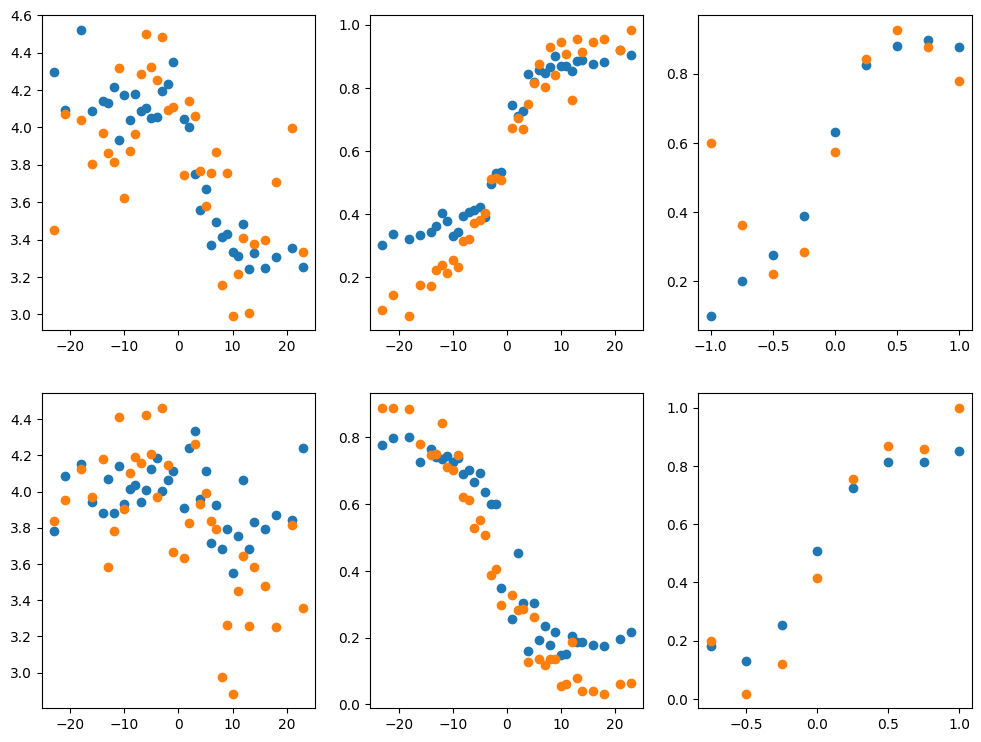

In [11]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(232)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(233)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

###########
plt.subplot(234)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(235)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(236)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

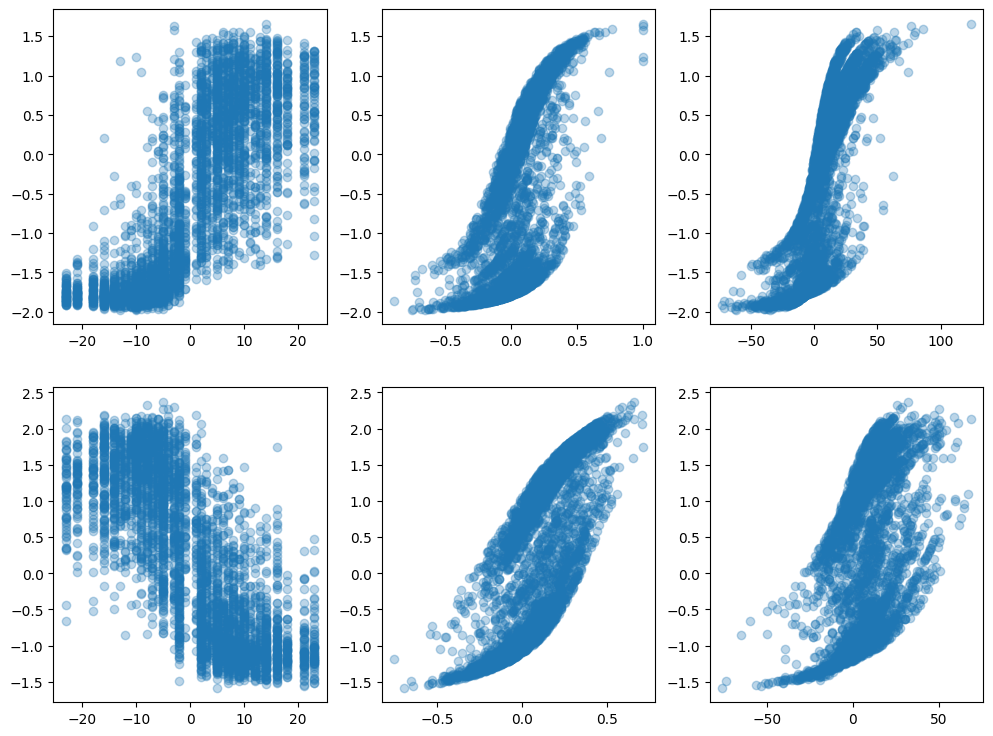

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 0] - X_test[X_test[:, -1]==1, 1], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 0] - X_test[X_test[:, -1]==-1, 1], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);